# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebook though as you work through this.

First off, let's load the dataset through torchvision.

In [16]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
# If the img has three channels, you should have three number for mean, for example, 
# img is RGB, mean is [0.5, 0.5, 0.5], the normalize result is R * 0.5, G * 0.5, B * 0.5. 
# If img is grey type that only one channel, so mean should be [0.5], the normalize result is R * 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
n_test_set = len(testset)
n_val_set = int(n_test_set/2)
n_test_set = n_test_set - n_val_set

print("n_val_set", n_val_set)
print("n_test_set", n_test_set)

# Randomly split the test_set into test_set and val_set
testset, valset = torch.utils.data.random_split(testset, [n_test_set, n_val_set])
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)

n_val_set 5000
n_test_set 5000


Here we can see one of the images.

image shape: torch.Size([128, 1, 28, 28])
label shape: torch.Size([128])


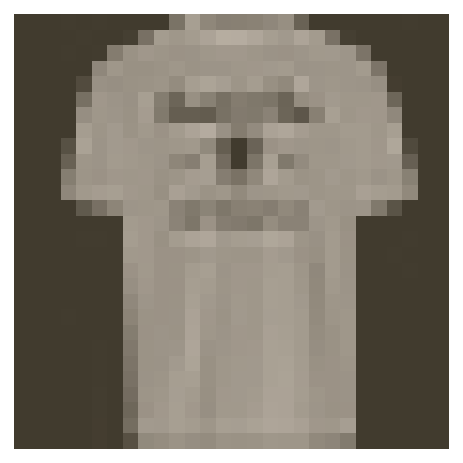

In [17]:
image, label = next(iter(trainloader))
print("image shape:", image.shape)
print("label shape:", label.shape)
helper.imshow(image[0,:]);

With the data loaded, it's time to import the necessary packages.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits from the forward pass. It's up to you how many layers you add and the size of those layers.

In [19]:
# Define network architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(kernel_size=(3, 3), in_channels=in_channels, out_channels=out_channels, 
                               stride=stride, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(kernel_size=(3, 3), in_channels=out_channels, out_channels=out_channels, 
                               stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to downsample residual
        # In case the output dimensions of the residual block is not the same 
        # as it's input, have a convolutional layer downsample the layer 
        # being bought forward by approporate striding and filters
        self.shortcut = nn.Sequential()
        if in_channels != out_channels and stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(kernel_size=(1, 1), in_channels=in_channels, out_channels=out_channels, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = nn.ReLU()(self.batch_norm1(self.conv1(x)))
        out = self.batch_norm2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out
            

In [20]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(
            kernel_size=(3, 3), in_channels=input_channels, out_channels=64, stride=1, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
#         self.block3 = self._create_block(128, 256, stride=2)
#         self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(1152, num_classes)
        
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(ResidualBlock(in_channels, out_channels, stride),
                             ResidualBlock(out_channels, out_channels, 1))
    
    def forward(self, x):
        out = nn.ReLU()(self.batch_norm1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
#         out = self.block3(out)
#         out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [21]:
# Create the network, define the criterion and optimizer
model = ResNet(input_channels=1)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
# Train the network

model.train()
for epoch in range(1):
    
    loss_list=[]
    for batch_idx, (images, labels) in enumerate(trainloader):
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        if batch_idx % 10 == 0:
            model.eval()
            total=0
            correct = 0
            with torch.no_grad():
                for _, (images, labels) in enumerate(valloader):
                    outputs_val = model(images)
                    _, predicted = torch.max(outputs_val.data, 1)
                    total += labels.size(0)
                    correct += predicted.eq(labels.data).sum()
                    
                acc=100.*correct/total
            print("epoch:{0}, batch index:{1}, loss:{2}, acc:{3}"
                  .format(epoch, batch_idx, np.mean(loss_list), acc))
            model.train()
                

epoch:0, batch index:0, loss:2.470595359802246, acc:10.140000343322754
epoch:0, batch index:10, loss:4.229300108822909, acc:13.819999694824219
epoch:0, batch index:20, loss:2.8138268760272434, acc:48.2400016784668
epoch:0, batch index:30, loss:2.183544441576927, acc:66.08000183105469
epoch:0, batch index:40, loss:1.8426596202501437, acc:72.05999755859375
epoch:0, batch index:50, loss:1.6188020180253422, acc:72.13999938964844
epoch:0, batch index:60, loss:1.4650205158796468, acc:77.19999694824219
epoch:0, batch index:70, loss:1.3485456251762282, acc:75.63999938964844
epoch:0, batch index:80, loss:1.2610262816334947, acc:52.880001068115234
epoch:0, batch index:90, loss:1.1891942482728224, acc:75.63999938964844
epoch:0, batch index:100, loss:1.1268698543605238, acc:79.26000213623047
epoch:0, batch index:110, loss:1.0735582725421802, acc:76.12000274658203
epoch:0, batch index:120, loss:1.0337792366496787, acc:80.73999786376953
epoch:0, batch index:130, loss:1.0000681740637043, acc:77.30000

img shape: torch.Size([1, 28, 28])
torch.Size([1, 10])


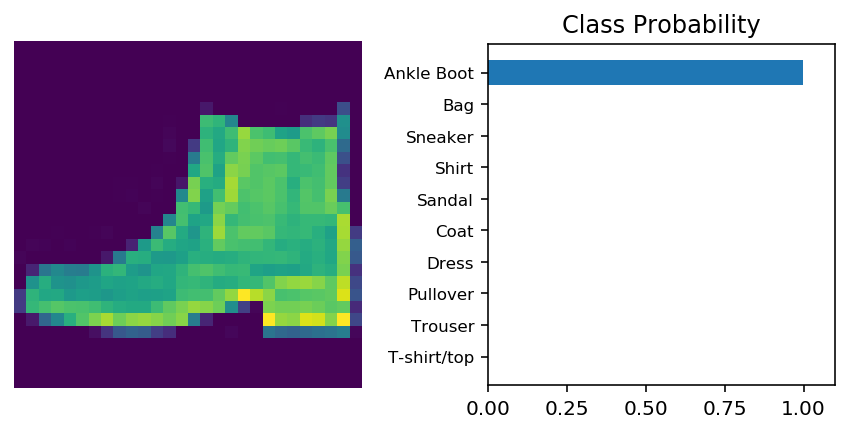

In [28]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
print("img shape:", img.shape)
# Convert img to the input format in which the first dimension is batch size
img = img.resize_(1, img.shape[0], img.shape[1], img.shape[2])

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

# ps = torch.exp(output)
ps = F.softmax(output, dim=1)
print(ps.shape)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')